In [427]:
''' 
https://github.com/Chan-dre-yi/POWER-CAST/blob/main/TFT_RUN.ipynb

https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

https://arshren.medium.com/implementation-of-time-series-forecasting-using-tft-cad68fff4288

'''

' \nhttps://github.com/Chan-dre-yi/POWER-CAST/blob/main/TFT_RUN.ipynb\n\nhttps://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html\n\nhttps://arshren.medium.com/implementation-of-time-series-forecasting-using-tft-cad68fff4288\n\n'

In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from pytorch_forecasting import Baseline,TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, QuantileLoss, MAE

from lightning.pytorch import Trainer

""" import lightning.pytorch as pl # Instead of import pytorch_lightning as pl """

' import lightning.pytorch as pl # Instead of import pytorch_lightning as pl '

### Inputs

In [429]:
epochs = 20

### Read data

In [430]:
df = pd.read_csv('airline-passengers.csv')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [431]:
df = df.rename(columns={'Month':'date',
                        'Passengers':'pass'
                        })
df

,date,pass
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [432]:
df.dtypes

date    object
pass     int64
dtype: object

In [433]:
df['date'] = (pd.to_datetime(df['date'])).dt.to_period('M')
df

,date,pass
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


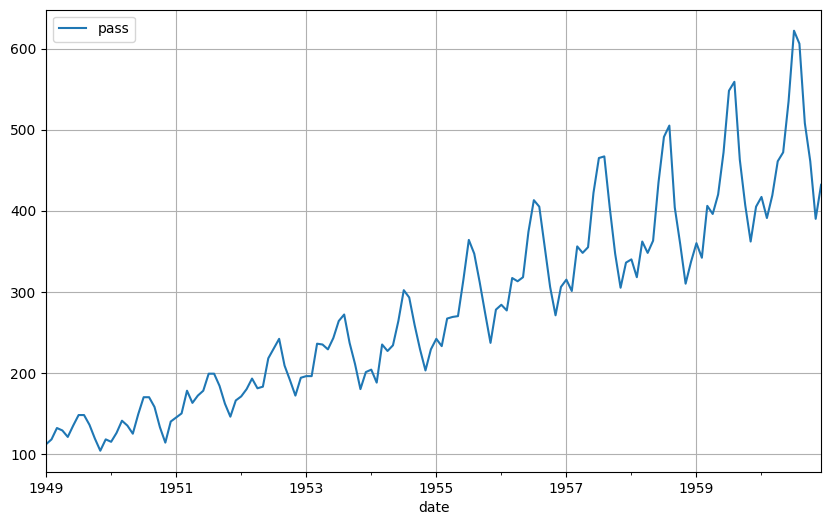

In [434]:
df.plot(figsize=(10,6),
        x='date',
        y='pass')
plt.grid(True)
plt.show()

### Add cols

In [435]:
# Ensure time_idx starts at 0 and increases sequentially
df["time_idx"] = range(len(df))

df["month"] = df["date"].dt.month

# If i have more time-series
df["group"] = 0

df

,date,pass,time_idx,month,group
0,1949-01,112,0,1,0
1,1949-02,118,1,2,0
2,1949-03,132,2,3,0
3,1949-04,129,3,4,0
4,1949-05,121,4,5,0
...,...,...,...,...,...
139,1960-08,606,139,8,0
140,1960-09,508,140,9,0
141,1960-10,461,141,10,0
142,1960-11,390,142,11,0


## TFT

### Training and validation

In [436]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length



training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="pass",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx", "month"],  # Known input (time index)
    time_varying_unknown_reals=["pass"],  # Unknown target
    target_normalizer=GroupNormalizer(groups=["group"])
)


In [437]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series

validation = TimeSeriesDataSet.from_dataset(
    training, df, predict=True, stop_randomization=True
)

### Dataloaders

In [438]:
# Create dataloaders for model

batch_size = 128  # set this between 32 to 128

train_dataloader = training.to_dataloader(train=True, 
                                          batch_size=batch_size, 
                                          num_workers=1
                                        )


val_dataloader = validation.to_dataloader(train=False, 
                                          batch_size=batch_size * 10, 
                                          num_workers=1
                                        )

### Baseline model

In [439]:
# Calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
mae = MAE()(baseline_predictions.output, baseline_predictions.y)
mae

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


tensor(84.5000)

### Find the best LR

In [440]:
#TODO:

### Train model

In [441]:
trainer = Trainer(max_epochs=epochs,
                  limit_train_batches=3,  # coment in for training, running valiation every 30 batches
                #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs 
                  #accelerator="auto"
                )

In [442]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    #output_size=1,
    loss=QuantileLoss(),
)

In [443]:
trainer.fit(tft, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
            #encoder_cat = None 
            #log_every_n_steps=1
            #val_dataloaders=val_dataloader
            )


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 48     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Tuning with Optuna

In [444]:
#TODO:

### Best model

In [445]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

best_model_path

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


'd:\\03_Coding\\Portfolio\\Machine_Learning\\Time_Series\\Temporal_Fusion_Transformer\\lightning_logs\\version_45\\checkpoints\\epoch=19-step=20.ckpt'

### Evaluate performance

In [446]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
mae=MAE()(predictions.output, predictions.y)
mae

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


tensor(105.3318)

### Final plot

In [447]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

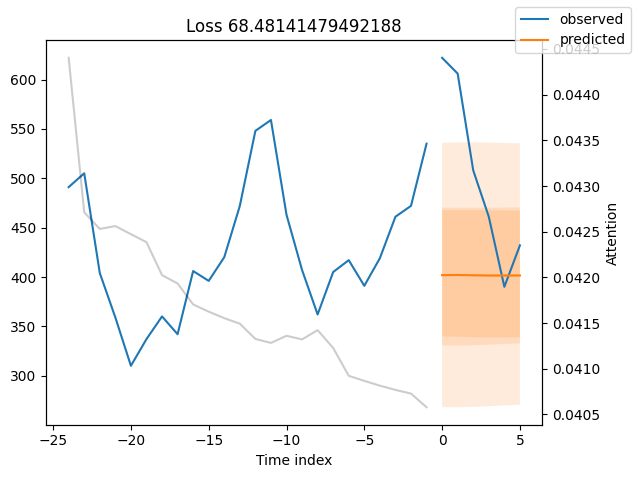

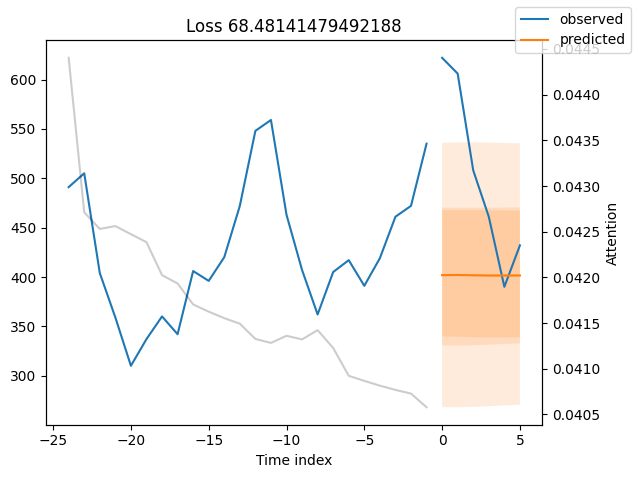

In [448]:
best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True
    )